# Zillow Project Report
By Jeremy Lagunas 07/27/2022

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from env import host, user, password
import wrangle

# Project Description

I will explore the zillow data set to answer a few questions concerning the relationship of certain variables. After gaining this insight I will begin feature engineering and modeling, with the overall goal to create an accurate predictive model of home price.

# Acquire

In [2]:
df = wrangle.new_zillow_data()

In [3]:
df.head(3)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,lotsizesquarefeet,regionidzip,yearbuilt,poolcnt,fireplacecnt
0,4.0,3.5,3100.0,1023282.0,4506.0,96978.0,1998.0,NaN,NaN
1,2.0,1.0,1465.0,464000.0,12647.0,97099.0,1967.0,NaN,1.0
2,3.0,2.0,1243.0,564778.0,8432.0,97078.0,1962.0,1.0,NaN


I acquired this data with the new_zillow_data funtion from the wrangle.py file. I reviewed the data on MySQL first and decided that these columns seemed most usefull. 

In [4]:
df.shape

(52441, 9)

# Prepare

In [5]:
df = wrangle.zillow_clean(df)

I changed the names of the columns to make them easier to read and work with.
The NaN's in fireplace and pool were changed to 0's

Limits: 
- at least one bedroom and bathroom but no more than six
- a price less than or equal to two million 
- square feet less than or equal to six thousand. 

In [105]:
df.head(3)

,bed,bath,square_feet,price,lot_square_feet,zipcode,year_built,pool,fireplace
0,4.0,3.5,3100.0,1023282.0,4506.0,96978.0,1998.0,0.0,0.0
1,2.0,1.0,1465.0,464000.0,12647.0,97099.0,1967.0,0.0,1.0
2,3.0,2.0,1243.0,564778.0,8432.0,97078.0,1962.0,1.0,0.0


In [6]:
df.shape

(50340, 9)

# Explore

## Questions:
1. Is there a relationship between house square feet and price?
2. Are houses with more bedrooms priced higher than houses with less bedrooms?
3. Are houses with more bathrooms priced higher than houses with less bathrooms?
4. Does the age of a house affect the price?
5. What are the best price predictors?

In [7]:
# splitting the data
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(df, test_size = 0.3, random_state = 123)

validate, test = train_test_split(valid_test, test_size = 0.5, random_state=123)

In [8]:
train.shape

(35238, 9)

In [9]:
validate.shape

(7551, 9)

In [10]:
test.shape

(7551, 9)

### What do the distributions look like?

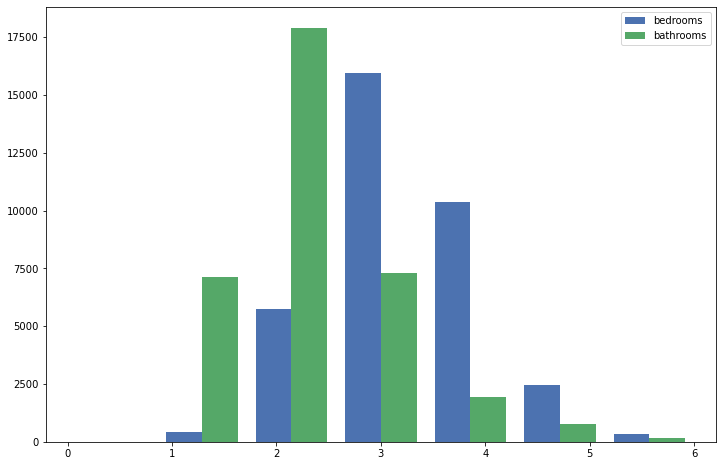

In [104]:
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-deep')

x = train.bed
y = train.bath
bins = np.linspace(0, 6, 8)

plt.hist([x, y], bins, label=['bedrooms', 'bathrooms'])
plt.legend(loc='upper right')
plt.show()

Bedrooms are normally distributed while bathrooms are pretty much normally distributed with a slight left skew.

<AxesSubplot:>

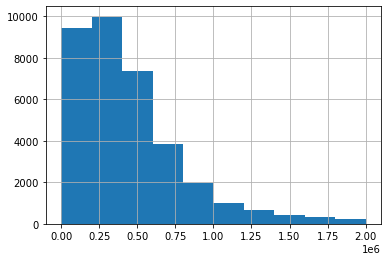

In [11]:
# histogram of home price to see the distribution
train.price.hist()

<AxesSubplot:>

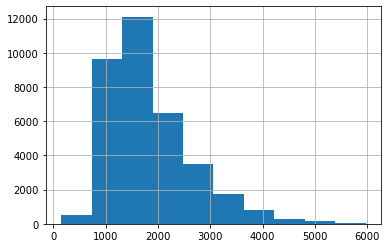

In [14]:
# histogram of the square feet to see the distribution
train.square_feet.hist()

Price and square feet are not normally distributed.

In [18]:
from scipy import stats

## 1. Is there a relationship between square feet and price?

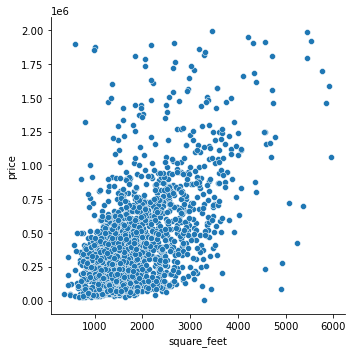

In [19]:
sns.relplot(data=train.sample(2000), x='square_feet', y='price')

There is a lot of noise, but there does appear to be some sort of relationship between square feet and price.

### Null Hypothesis: There is no relationship between square feet and price. 

### Alternative Hypothesis: There is a relationship between square feet and price.

In [20]:
# Because both price and square feet are continuous, and because the data is not normally distributed, I will be using the spearman r test.
corr, p = stats.spearmanr(train.square_feet, train.price)
corr, p

(0.4946459832902056, 0.0)

Based on the test I can reject the null hypothesis, seeing as how there appears to be a relationship between square feet and price, answering question #1.

## 2. Are houses with more bedrooms priced higher than houses with less bedrooms?
## Or, Does the number of bedrooms affect the price of a house?

In [28]:
mean_price_per_room = {'1':round(train.price[train.bed==1].mean()), '2':round(train.price[train.bed==2].mean()), '3':round(train.price[train.bed==3].mean()), '4':round(train.price[train.bed==4].mean()), '5':round(train.price[train.bed==5].mean()), '6':round(train.price[train.bed==6].mean())}

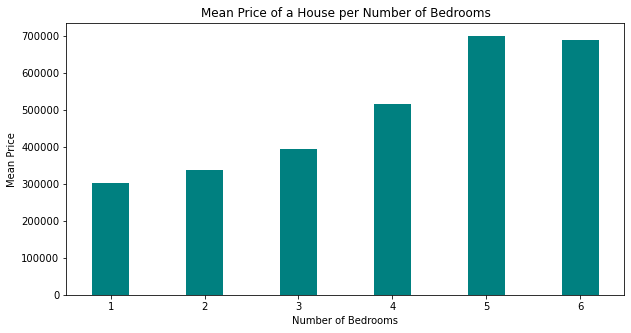

In [38]:
houses = list(mean_price_per_room.keys())
values = list(mean_price_per_room.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(houses, values, color ='teal',
        width = 0.4)
 
plt.xlabel("Number of Bedrooms")
plt.ylabel("Mean Price")
plt.title("Mean Price of a House per Number of Bedrooms")
plt.show()

Based on the chart it looks like there is a relationship between the number of bedrooms and price.

### Null Hypothesis: There is no relationship between the number of bedrooms and the price of a house. 

### Alternative Hypothesis: There is a relationship between the number of bedrooms and the price of a house.

In [36]:
# I'm using the one-way ANOVA test because I'm testing to see if > two groups (number of rooms) have the same population (price) mean.
alpha = 0.05
f, p = stats.f_oneway(train.price[train.bed == 1], train.price[train.bed == 2], train.price[train.bed == 3], train.price[train.bed == 4], train.price[train.bed == 5], train.price[train.bed == 6])
f, p

(602.9306976143548, 0.0)

Based on the test I can reject the null hypothesis that the number of bedrooms does not affect the price of the house, answering quaetion #2. 

## 3. Are house with more bathrooms priced higher than houses with less bathrooms?
## Or, Does the number of bathrooms affect the price of a house?

In [39]:
mean_price_per_bathroom = {'1':round(train.price[train.bath==1].mean()), '2':round(train.price[train.bath==2].mean()), '3':round(train.price[train.bath==3].mean()), '4':round(train.price[train.bath==4].mean()), '5':round(train.price[train.bath==5].mean()), '6':round(train.price[train.bath==6].mean())}

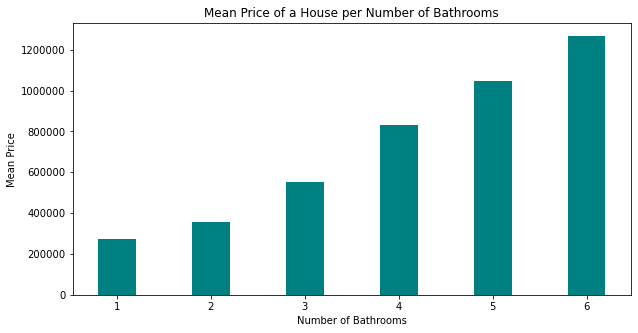

In [44]:
bathrooms = list(mean_price_per_bathroom.keys())
values = list(mean_price_per_bathroom.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(bathrooms, values, color ='teal',
        width = 0.4)

plt.xlabel("Number of Bathrooms")
plt.ylabel("Mean Price")
plt.title("Mean Price of a House per Number of Bathrooms")
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

Based on the chart, it looks like there is a relationship between the number of bathrooms and price.

### Null Hypothesis: There is no relationship between the number of bathrooms and the price of a house.

### Alternative Hypothesis: There is a relationship between the number of bathrooms and the price of a house.

In [45]:
# I'm using the one-way ANOVA test because I'm testing to see if > two groups (number of bathrooms) have the same population (price) mean.
alpha = 0.05
f, p = stats.f_oneway(train.price[train.bath == 1], train.price[train.bath == 2], train.price[train.bath == 3], train.price[train.bath == 4], train.price[train.bath == 5], train.price[train.bath == 6])
f, p

(1657.438552369102, 0.0)

Based on the test results I can reject the null hypothesis that there is no relationship between the number of bathrooms and the price of a house, answering question #3.

## 4. Does the age of a house affect price?

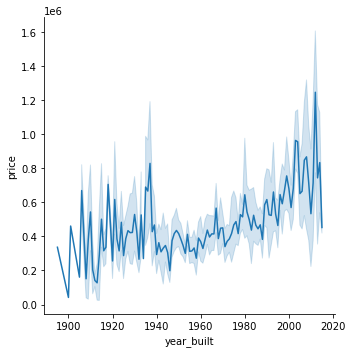

In [46]:
sns.relplot(data=train.sample(2000), x='year_built', y='price', kind='line')

Based on the chart there does appear to be a relationship between the age of the house (or year built) and price.

In [47]:
corr, p = stats.spearmanr(train.year_built, train.price)
corr, p

(0.2690936037540229, 0.0)

Based on the test results I can reject the null hypothesis that there is no relationship between the age of the house and the price, answering question #4.

### Exploration Summary

After exploring the data I have found several variables which have a relationship with our target variable price. These are: square feet, bedrooms, bathrooms, and year built. This is good information to keep in mind as I begin constructing my model.

### X, Y

In [48]:
# Here I am separating the x (features) and y (target) so that I may begin feature enginerring and modeling. 
y_train = train.price
x_train = train.drop(columns = ['price'])

y_validate = validate.price
x_validate = validate.drop(columns = ['price'])

y_test = test.price
x_test = test.drop(columns = ['price'])

In [49]:
y_test = pd.DataFrame(y_test, columns = ['price'])

In [50]:
y_test.head(2)

,price
29998,461623.0
20688,485164.0


In [51]:
import sklearn.preprocessing

## Feature Engineering

### Select K Best

In [52]:
# I am using the MinMaxScaler to scale my data so it can be better used in modeling.
scaler = sklearn.preprocessing.MinMaxScaler()

scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression

In [54]:
kbest = SelectKBest(f_regression, k=3)

kbest.fit(x_train_scaled, y_train)

SelectKBest(k=3, score_func=<function f_regression at 0x150073ee0>)

In [55]:
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train.columns)

In [56]:
kbest_results

,p,f
bed,0.000000e+00,2734.808056
bath,0.000000e+00,11537.734892
square_feet,0.000000e+00,17001.894530
lot_square_feet,1.139272e-01,2.499005
zipcode,8.755571e-02,2.918911
year_built,0.000000e+00,2165.034881
pool,0.000000e+00,1942.453232
fireplace,2.687379e-114,520.118817


The Select K Best shows that square_feet, bathrooms, and bedrooms are the best features, answering question #5.

### RFE

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, f_regression, SequentialFeatureSelector

In [58]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select = 3)
rfe.fit(x_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [59]:
var_ranks = rfe.ranking_

In [60]:
var_names = x_train.columns.tolist()

In [61]:
rfe_ranks_df = pd.DataFrame({'Var':var_names, 'Rank':var_ranks})

In [62]:
rfe_ranks_df.sort_values('Rank')

,Var,Rank
0,bed,1
2,square_feet,1
3,lot_square_feet,1
1,bath,2
5,year_built,3
7,fireplace,4
4,zipcode,5
6,pool,6


The RFE shows that bedrooms, square feet, and lot square feet are the best features, answering question #5.

In [155]:
# Here I will be dropping the columns I do not intend to use during the modeling phase. 
x_train_model = x_train.drop(columns=['fireplace', 'pool', 'zipcode', 'year_built', 'lot_square_feet'])
scaler.fit(x_train_model)
x_train_model = scaler.transform(x_train_model)

x_validate_model = x_validate.drop(columns=['fireplace', 'pool', 'zipcode', 'year_built', 'lot_square_feet'])
x_validate_model = scaler.transform(x_validate_model)

x_test_model = x_test.drop(columns=['fireplace', 'pool', 'zipcode', 'year_built', 'lot_square_feet'])
x_test_model = scaler.transform(x_test_model)

After feature engineering, and taking into account my exploration, I've decided to complete this project with these three features: 
- bedrooms
- bathrooms
- square feet

## Baseline

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [64]:
y_train.mean()
# The baseline rediction will be the mean price froms the train dataset.

442804.77603723254

In [65]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
# Changes the y train and validate data to dataframes for easier use later.

In [66]:
y_train['baseline'] = y_train.price.mean()
y_validate['baseline'] = y_validate.price.mean()
# Establishing the baseline values for train and validate datasets.

In [67]:
y_train.head(3)

,price,baseline
49316,692000.0,442804.776037
50671,345767.0,442804.776037
28115,1487435.0,442804.776037


The baseline prediction value is $442,804.77

In [68]:
rmse_train = mean_squared_error(y_train.price, y_train.baseline)**(1/2)
rmse_validate = mean_squared_error(y_validate.price, y_validate.baseline)**(1/2)

In [69]:
rmse_train

352181.7661389873

In [70]:
rmse_validate

355365.5610374661

The baseline value to beat is 355365.56

## Train
## Linear Regression (OLS)

In [163]:
# establish the algorithm
lm = LinearRegression(normalize=True)

In [164]:
# fit the algorithm to the data
lm.fit(x_train_model, y_train.price)

LinearRegression(normalize=True)

In [174]:
# generate predictions based on the data it received
y_train['price_pred_lm'] = lm.predict(x_train_model)
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_lm)**(1/2)

In [172]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train)

RMSE for OLS using LinearRegression
Training/In-Sample:  284982.0412820465


## Lasso Lars

In [141]:
# establish the algorithm
lars = LassoLars(alpha=1.0)

In [160]:
# fit the algorithm to the data
lars.fit(x_train_model, y_train.price)

LassoLars()

In [161]:
# generate predictions based on the data it received
y_train['price_pred_lars'] = lars.predict(x_train_model)
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_lars)**(1/2)

In [179]:
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train)

RMSE for Lasso + Lars
Training/In-Sample:  285077.4400428301


## Tweedie Regressor (GLM)

In [145]:
# establish the algorithm
glm = TweedieRegressor(power=1, alpha=0)

In [146]:
# fit the algorithm to the data
glm.fit(x_train_model, y_train.price)

TweedieRegressor(alpha=0, power=1)

In [147]:
# generate predictions based on the data it received
y_train['price_pred_glm'] = glm.predict(x_train_model)
rmse_train = mean_squared_error(y_train.price, y_train.price_pred_glm)**(1/2)

In [180]:
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  285077.4400428301


Based on the performance of these models, I believe I should move forward with validating only the Linear Regression and Lasso Lars models.

## Validate
## Linear Regression (OLS)

In [175]:
# generate predictions with validate data
y_validate['price_pred_lm'] = lm.predict(x_validate_model)
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_lm)**(1/2)

In [176]:
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Validation/Out-of-Sample:  288524.21105117653


## Lasso Lars

In [177]:
# generate predicstions with validate data
y_validate['price_pred_lars'] = lars.predict(x_validate_model)
rmse_validate = mean_squared_error(y_validate.price, y_validate.price_pred_lars)**(1/2)

In [178]:
print("RMSE for Lasso + Lars\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Validation/Out-of-Sample:  288430.01255722693


Based on the performace on validate, I will be using Lasso Lars on the Test data.

# Test

## Lasso Lars

In [181]:
# generate predictions with test data
y_test['price_pred_lars'] = lars.predict(x_test_model)
rmse_test = mean_squared_error(y_test.price, y_test.price_pred_lars)**(1/2)

In [182]:
rmse_test

279883.6498976515

rmse_baseline = 355365.56

The model's performance on the test dataset outperformed the baseline by about 20%.

# Conclusion / Takeaways

### Questions:
1. Is there a relationship between house square feet and price?   Yes
2. Are houses with more bedrooms priced higher than houses with less bedrooms?   Yes
3. Are houses with more bathrooms priced higher than houses with less bathrooms?   Yes
4. Does the age of a house affect the price?   Yes
5. What are the best price predictors?   SKB: bed, bath, square feet.    RFE: bed, square feet, lot square feet

### Recommendations:

Use our models to try and buy houses we believe will sell for a higher price.

### Next Steps:

Refine the model by introducing new variables and reconfiguring the model specifications. This will help to better implement my recommendation.